In [1]:
using DataFrames, Plots, StatsBase, GaussianMixtures, Distributions, CSV, Random, DynamicPolynomials;

In [2]:
df = DataFrame(CSV.File("../data/exam-grades-distribution-fictional.csv"));

In [3]:
results = df.result;
DataFrame("no. participants"=> length(results), "mean result" => mean(results), "min result" => min(results...), "max result" => max(results...))

,no. participants,mean result,min result,max result
,Int64,Float64,Float64,Float64
1,81,35.7037,2.0,95.0


In [4]:
# 43 and 37 seem by far the most common grades.
# but you may try along with various seeds.

# Random.seed!(1232839282243298982334344) # yields 37 as passing grade 
#Random.seed!(31334387483723) # yields 43 as passing grade
Random.seed!(222227384738422) # yields 37 as passing grade

gmm = GMM(2, reshape(Float64.(results), length(results), 1); method=:kmeans, kind=:diag, nInit=50, nIter=10, nFinal=10)

gauss1 = Normal(gmm.μ[1], √gmm.Σ[1]);
gauss2 = Normal(gmm.μ[2], √gmm.Σ[2]);
gmm_dist = MixtureModel(Normal[
   gauss1,
   gauss2], gmm.w)
@polyvar X

Σ = gmm.Σ[sortperm(vec(gmm.μ))]
μ = gmm.μ[sortperm(vec(gmm.μ))]
p = -0.5*log(Σ[1]) - 0.5*(X-μ[1])^2/Σ[1] + 0.5*log(Σ[2]) + 0.5*(X-μ[2])^2/Σ[2]
posroot_quadratic = function(p)
    a, b, c = coefficients(p)
    d = sqrt(b^2 - 4a*c)
    return max((-b - d) / 2a, (-b + d) / 2a)
end
passing_grade = Int(floor(posroot_quadratic(p)));
println("Passing grade: $passing_grade");

┌ Info: Initializing GMM, 2 Gaussians diag covariance 1 dimensions using 81 data points
└ @ GaussianMixtures /home/alexander/.julia/packages/GaussianMixtures/zDaBV/src/train.jl:79


K-means converged with 4 iterations (objv = 12171.490243902444)


┌ Info: K-means with 81 data points using 4 iterations
│ 20.2 data points per parameter
└ @ GaussianMixtures /home/alexander/.julia/packages/GaussianMixtures/zDaBV/src/train.jl:141


Passing grade: 37


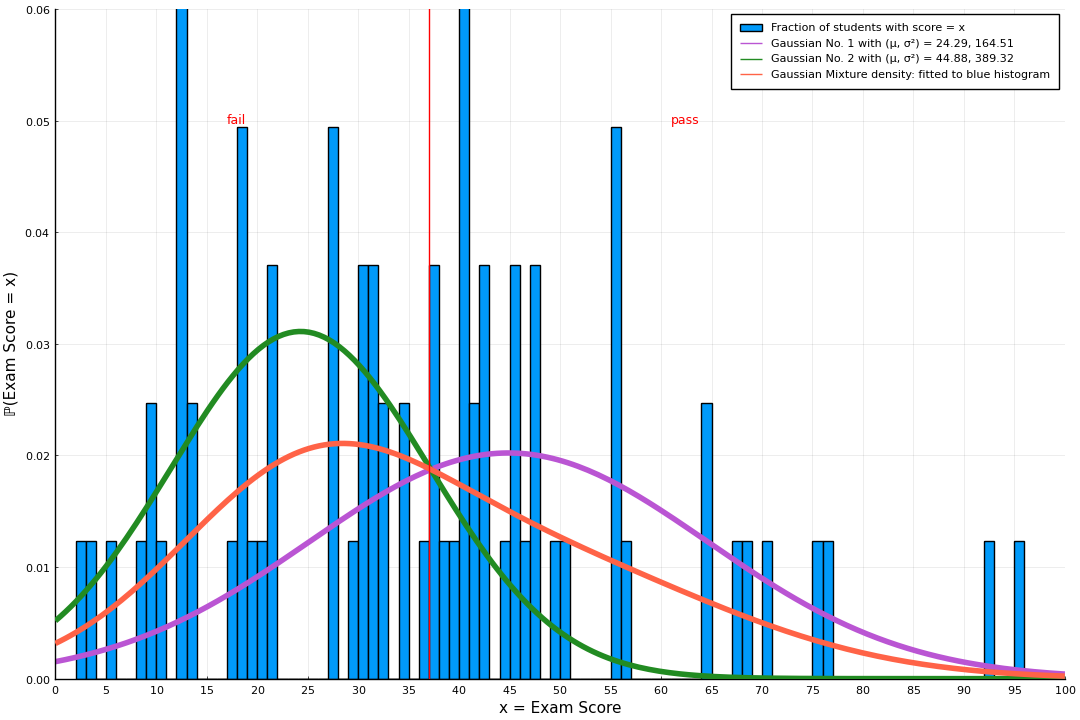

In [5]:
pyplot()
plot(size=(1080, 720))
xaxis = ("x = Exam Score", (0, 100), 0:5:100)
yaxis = ("ℙ(Exam Score = x)", (0, 0.06))
histogram!(results, bins=100; normed=true, xaxis=xaxis, yaxis=yaxis, label="Fraction of students with score = x ")
start =  0;
fin   =  100;
scale =  1;
plot!(x->x, x -> scale*pdf(gauss2, x),   start, fin, line = 4, label="Gaussian No. 1 with (μ, σ²) = $(round(μ[1], digits=2)), $(round(Σ[1], digits=2)) ", color="mediumorchid" )
plot!(x->x, x -> scale*pdf(gauss1, x),   start, fin, line = 4, label="Gaussian No. 2 with (μ, σ²) = $(round(μ[2], digits=2)), $(round(Σ[2], digits=2)) ", color="forestgreen")
plot!(x->x, x -> scale*pdf(gmm_dist, x), start, fin, line = 4, leg = :best, label="Gaussian Mixture density: fitted to blue histogram", color="tomato")

vline!([passing_grade]; color = "red", label=:none)

annotate!([(17, 0.05, ("fail", 9, :red, :left))])
annotate!([(61, 0.05, ("pass", 9, :red, :left))])